In [1]:
import pickle
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse, rmse_network
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Simulation parameters
RUNS = 1
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 100
q = 9.5e-5  # Process noise intensity
r = 5  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant

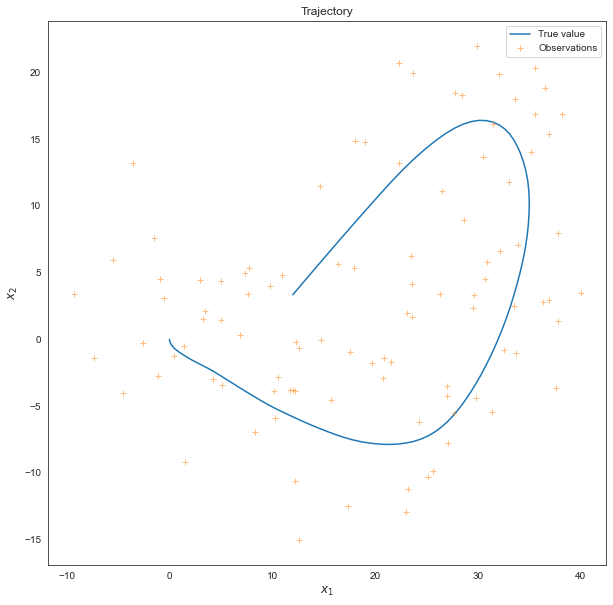

In [4]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=False, random_seed=RANDOM_SEED
)

plot_traj(traj, obs=0)

In [5]:
rwm1 = KalmanFilter(RWModel(q, r))
rwm2 = KalmanFilter(RWModel(c_rwm * q, r))
rwm3 = KalmanFilter(RWModel(c_rwm * q, r))

for yt in traj.observations:
    rwm1.predict()
    rwm1.update(yt, log=True)

    rwm2.predict()
    rwm2.update(yt, log=True)

    rwm3.predict()
    rwm3.update(yt, log=True)
    rwm3.model.Q *= 1 / 0.90

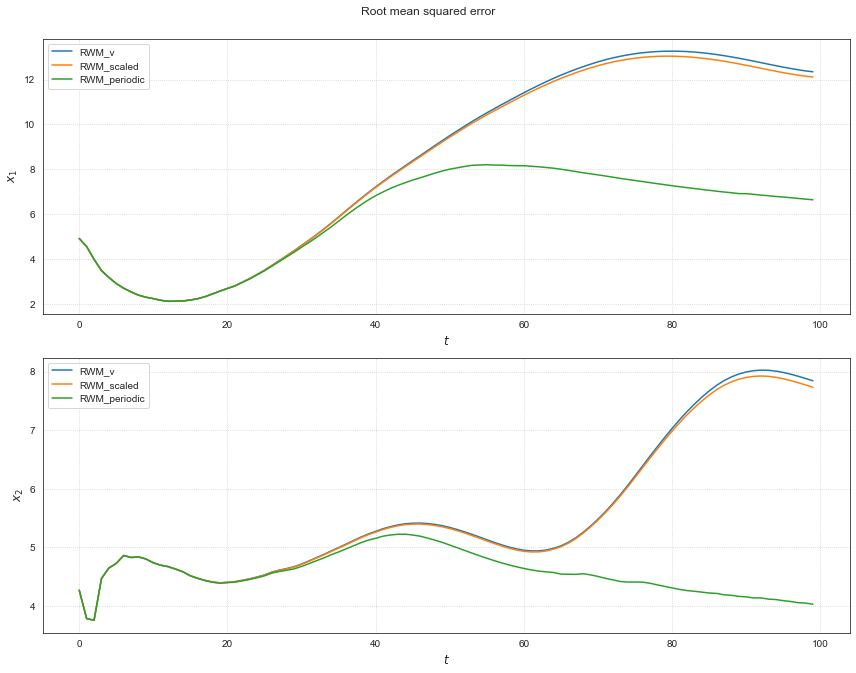

In [6]:
plot_rmse(
    traj,
    rwm1,
    rwm2,
    rwm3,
    nvars=2,
    var_labels=["$x_1$", "$x_2$"],
    kf_labels=["RWM_v", "RWM_scaled", "RWM_periodic"],
)

In [7]:
dfs = []
for rwm in (rwm1, rwm2, rwm3):
    dfs.append(rwm.to_dataframe(traj))

In [8]:
# cols = ["x1_est", "x2_est", "x1_std", "x2_std", "x1_real", "x2_real"]
# for i, df in enumerate(dfs):
#     df[cols].to_csv(f"rwm_{i}.csv", index_label="t")

In [9]:
cols = ["rmse11", "rmse12", "rmse21", "rmse22", "rmse31", "rmse32"]
rmse_data = rmse_network([], traj, ndat, 2, rwm1, rwm2, rwm3)

df = pd.DataFrame(rmse_data, columns=cols)
df.head()
# df.to_csv("rmse_data.csv", index_label="t")

,rmse11,rmse12,rmse21,rmse22,rmse31,rmse32
0,4.922283,4.269325,4.922283,4.269325,4.922283,4.269325
1,4.565763,3.785437,4.565754,3.785425,4.565753,3.785423
2,3.996600,3.755998,3.996559,3.755996,3.996551,3.755997
3,3.495526,4.469340,3.495462,4.469498,3.495446,4.469552
4,3.189144,4.648121,3.189071,4.648261,3.189055,4.648301
